In [1]:
import numpy as np
from parameters import *
from models import geophysic_models
from autograd import grad
from autograd import elementwise_grad as egrad 
from scipy.misc import *
from joblib import *

# location = './cachedir'
# memory = Memory(location, verbose=0)

def evalutate_linear_model(x, A, b, d, T, initial_state):
    vecteur = []
    state = initial_state
    for t in range(T):
        state = A @ state + d * x[t]
        vecteur.append(b @ state)
    return np.array(vecteur)

def derivative_damage(x, damage_func):
    return derivative(damage_func, x, order=5)

def jacobian_damage_function(x, damage_func):
    return np.array(derivative_damage(x, damage_func))

def jacobian_sum(t_periode, n_player):
        
    matrice = np.zeros((t_periode, n_player * t_periode))
    for i in range(n_player * t_periode):
        k = i//n_player
        matrice[k,i] = 1

    return matrice

def jacobian_linear_model(A, b, d, T):
    T_matrix = np.diag(np.repeat(np.dot(b, d), T))
    for i in range(T):
        for j in range(i):
            T_matrix[i,j] = np.dot(b, np.linalg.matrix_power(A, i-j) @ d) # Eléments au-dessous de la diagonale
    return T_matrix

# jacobian_linear_model = memory.cache(jacobian_linear_model)

def jacobian_forcing(atmospheric_carbon : np.ndarray, Fx2CO2 = F_2XCO2):
    return np.diag(atmospheric_carbon**(-1)) * Fx2CO2 / np.log(2)


def jacobian_damage(a : np.ndarray, damage_func : damage_function,  SCM : Simple_Climate_Model):

    n_player, t_periode = a.shape
    sum_a = np.sum(a, axis=0)

    CC = SCM.carbon_model
    TD = SCM.temperature_model

    carbon_AT = evalutate_linear_model(sum_a, CC.Ac, CC.bc, CC.dc, t_periode, SCM.carbon_state)
    if CC.name == 'Joos-et-al':
        carbon_AT += C_1750
    forcing = radiative_forcing_function(carbon_AT) + F_EX[:t_periode]
    temperature_AT = evalutate_linear_model(forcing, TD.At, TD.bt, TD.dt, t_periode, SCM.temperature_state)

    jac_carbon_AT = jacobian_linear_model(CC.Ac, CC.bc, CC.dc, t_periode)
    jac_forcing = jacobian_forcing(carbon_AT)
    jac_temperature_AT = jacobian_linear_model(TD.At, TD.bt, TD.dt, t_periode)
    # jac_damage = np.tile(jacobian_damage_function(temperature_AT, damage_func),[n_player,1])
    jac_damage = jacobian_damage_function(temperature_AT, damage_func)
    jac_sum = jacobian_sum(t_periode, n_player)
    
    jacobian =  jac_damage @ jac_temperature_AT @ jac_forcing @ jac_carbon_AT @ jac_sum
    # jacobian = np.kron(jacobian_one_player, np.ones(N))
    # jacobian = jacobian_one_player.repeat(n_player)

    return jacobian


# evalutate_linear_model = memory.cache(evalutate_linear_model)


def potential(n_player, t_periode, a : np.ndarray, list_benefit : list[callable], list_weight : list[float], damage_func : damage_function, SCM : Simple_Climate_Model):

    a = np.reshape(a, (n_player,t_periode), 'F' )
    sum_a = np.sum(a, axis=0)

    CC = SCM.carbon_model
    TD = SCM.temperature_model

    carbon_AT = evalutate_linear_model(sum_a, CC.Ac, CC.bc, CC.dc, t_periode, SCM.carbon_state) 
    if CC.name == 'Joos-et-al':
        carbon_AT += C_1750
    forcing = radiative_forcing_function(carbon_AT) + F_EX[:t_periode]
    temperature_AT = evalutate_linear_model(forcing, TD.At, TD.bt, TD.dt, t_periode, SCM.temperature_state)

    benefit = sum([1/DELTAS[j] *  sum([list_benefit[j](GDP_MAX[j], ACTION_SETS[j,1])(a[j,i]) for i in range(t_periode)]) for j in range(n_player)])
    damage = sum(damage_func(temperature_AT))
    value = benefit - damage

        
    return value

def jacobian_benefice(a : np.ndarray, list_benefit : list[callable], list_weight : list[float]):
    n_player, t_periode = a.shape

    diag = [1/list_weight[j] *  derivative(list_benefit[j](GDP_MAX[j], ACTION_SETS[j,1]),a[j,i]) for i in range(t_periode) for j in range(n_player)]
    return np.array(diag).T

def jacobian_potential(n_player, t_periode, a : np.ndarray, list_benefit : list[callable], list_weight : list[float], damage_func : callable, scm : Simple_Climate_Model):
    a = np.reshape(a,(n_player, t_periode),'F') # the reshape function is weird it's important
    return jacobian_benefice(a, list_benefit, list_weight) - jacobian_damage(a, damage_func, scm)


def eval_scm(path, SCM : Simple_Climate_Model):
    CC = SCM.carbon_model
    TD = SCM.temperature_model

    carbon_AT = evalutate_linear_model(path, CC.Ac, CC.bc, CC.dc, T, CC.initial_state) 
    if CC.name == 'Joos-et-al':
        carbon_AT += C_1750
    forcing = radiative_forcing_function(carbon_AT) + F_EX[:len(path)]
    temperature_AT = evalutate_linear_model(forcing, TD.At, TD.bt, TD.dt, T, TD.initial_state)
    return temperature_AT, carbon_AT
    

In [4]:


T = 37

def jacobian_damage_function(x, damage_func):
    return np.array(derivative_damage(x, damage_func))

damage_func = damage_polynome([0,0,0,1,0])
scm = Simple_Climate_Model(Carbon_JOOS(), Temp_Discret_Geoffroy())


def potential_wrapped(a):
    return -potential(N, T, a, BENEFITS_CONVEX, DELTAS, damage_func,  scm)


def jacobian_potential_wrapped(a):
    return -jacobian_potential( N, T, a, BENEFITS_CONVEX, DELTAS, damage_func,  scm)



In [10]:
from tqdm import tqdm

bound_ = []
for idx in range(T) : 
    bound_.append(ACTION_SETS[:,1]*max(0, (5-idx)/10))
bound_ = np.array(bound_).flatten()

from scipy.optimize import *


bounds = np.tile(ACTION_SETS, (T,1))
boundaries = Bounds(lb=bound_, ub=bounds[:,1], keep_feasible=True)

import scipy.stats as stat
seeds = [31 , 5, 19, 96, 94, 7, 42, 11, 13]
seeds = np.arange(5)*500
random_initial_point = [stat.uniform.rvs(bounds[:,0], bounds[:,1], random_state = seed) for seed in seeds]
random_initial_point = []
random_initial_point.append(bounds[:,0])
random_initial_point.append(bounds[:,1])
random_initial_point.append(bounds[:,1]/2)
random_initial_point = np.linspace(0,1,11)  
random_initial_point  = [random_point* (bounds[:,1]) + (1 -random_point) * bound_ for random_point in random_initial_point]
results = []
for random_point in tqdm(random_initial_point):
    res = minimize(potential_wrapped ,x0=random_point , bounds=boundaries, jac = jacobian_potential_wrapped)
    if res.success :
        results.append(res)
actions = [result.x.reshape((T,N)).T for result in results]
paths = [np.sum(result.x.reshape((T,N)).T, axis=0) for result in results]
len(paths)

100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


11

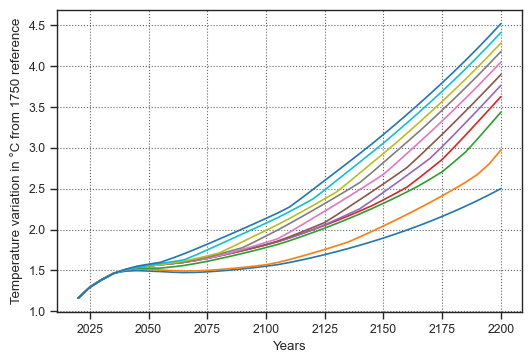

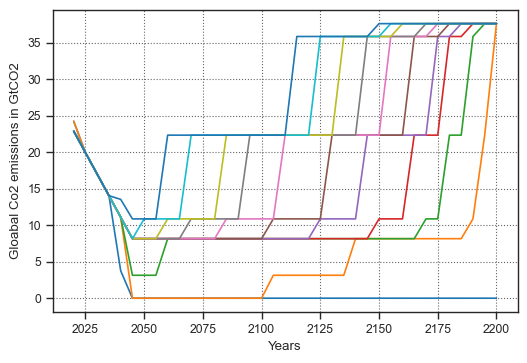

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')

X = np.arange(T)* 5 + 2020

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, eval_scm(path_, scm)[0])
plt.xlabel('Years')
plt.ylabel('Temperature variation in °C from 1750 reference')
plt.show()

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, path_)
plt.xlabel('Years')
plt.ylabel('Gloabal Co2 emissions in GtCO2')

plt.show()

# fig, ax = plt.subplots(nrows=4,ncols=3, dpi=140, figsize=(9,6))
# for k, result in enumerate(results):
#     for i in range(N):
#         ax[k//3,k%3].plot(X, result.x.reshape((T,N)).T[i])

plt.show()

In [12]:
sum(ACTION_SETS[:,1])

37.6

In [ ]:
utility_path = []
for k, path_ in enumerate(paths[-3:]):
        
    utility = []
    for i in range(N):
        utility.append( np.array([1/DELTAS[i] *  np.array([BENEFITS_CONVEX[i](GDP_MAX[i], ACTION_SETS[i,1])(actions[k][i,t]) for t in range(T)]) - np.array(damage_func(eval_scm(path_, scm)[0]))]))
    utility_path.append(utility)

<Figure size 1000x500 with 0 Axes>

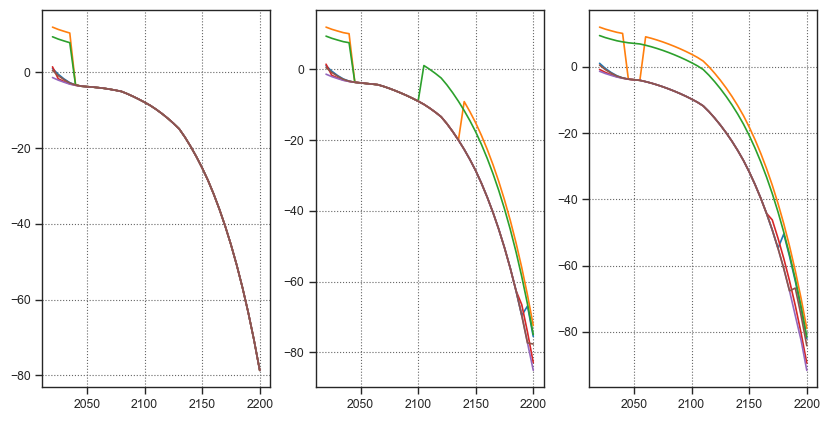

In [14]:
plt.figure(dpi=100, figsize =(10,5))
fig, ax = plt.subplots(1,3, dpi=100, figsize =(10,5))
for k in range(3):

    for i in range(N):
        ax[k].plot(X, utility_path[k][i].T)

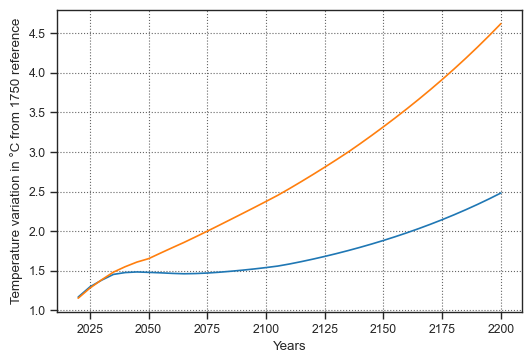

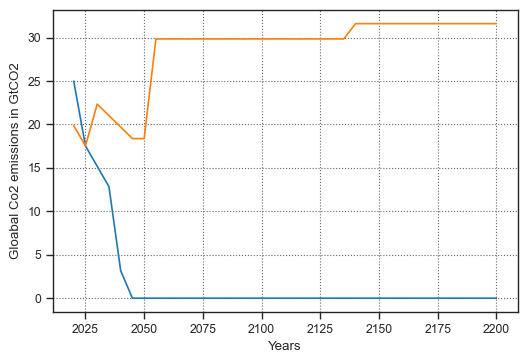

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')

X = np.arange(T)* 5 + 2020

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, eval_scm(path_, scm)[0])
plt.xlabel('Years')
plt.ylabel('Temperature variation in °C from 1750 reference')
plt.show()

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, path_)
plt.xlabel('Years')
plt.ylabel('Gloabal Co2 emissions in GtCO2')

plt.show()

# fig, ax = plt.subplots(nrows=4,ncols=3, dpi=140, figsize=(9,6))
# for k, result in enumerate(results):
#     for i in range(N):
#         ax[k//3,k%3].plot(X, result.x.reshape((T,N)).T[i])

plt.show()

In [21]:
sum(np.diff(paths, axis=0))

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.59972840e-05,  5.48622551e-06,  2.62797488e-05,
        4.36281553e-05,  5.76243604e-05,  8.10135184e-05,  5.85463455e-05,
        4.48376907e-05,  4.77653210e-05,  3.62085305e-05, -3.89427569e-06,
        5.34874284e-05, -3.58957969e-05, -3.87760279e-05,  5.55597667e-06,
       -1.06910086e-05, -4.89909255e-06, -1.01155806e-05, -4.15330464e-05,
       -8.87467755e-05, -1.02975218e-04, -6.55892327e-05, -6.73752714e-05,
       -3.08639426e-06,  5.28851436e-06, -1.36142789e-04, -1.54099381e-04,
        1.10308692e-03, -2.69177750e-04, -1.52765205e-03, -1.37773246e-03,
       -2.67465070e-03])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')

X = np.arange(T)* 5 + 2020

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, eval_scm(path_, scm)[0])
plt.show()

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, path_)
plt.show()

fig, ax = plt.subplots(nrows=4,ncols=3, dpi=140, figsize=(9,6))
for k, result in enumerate(results):
    for i in range(N):
        ax[k//3,k%3].plot(X, result.x.reshape((T,N)).T[i])

plt.show()

In [ ]:
y, c = eval_scm(paths[-1],scm)

In [ ]:
plt.plot(X,c/C_1750)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')

X = np.arange(T)* 5 + 2020

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, eval_scm(path_, scm))
plt.show()

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, path_)
plt.show()

fig, ax = plt.subplots(nrows=2,ncols=3, dpi=140, figsize=(9,6))
for k, result in enumerate(results):
    for i in range(N):
        ax[k%2,k%3].plot(X, result.x.reshape((N,T))[i])

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')

X = np.arange(T)* 5 + 2020

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, eval_scm(path_, scm))
plt.show()

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, path_)
plt.show()

fig, ax = plt.subplots(nrows=2,ncols=3, dpi=140, figsize=(9,6))
for k, result in enumerate(results):
    for i in range(N):
        ax[k%2,k%3].plot(X, result.x.reshape((N,T))[i])

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')

X = np.arange(T)* 5 + 2020

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, eval_scm(path_, scm))
plt.show()

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, path_)
plt.show()

fig, ax = plt.subplots(nrows=2,ncols=3, dpi=120)
for k, result in enumerate(results):
    for i in range(N):
        ax[k%2,k%3].plot(X, result.x.reshape((N,T))[i])

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=3, dpi=100)
for k, result in enumerate(results):
    for i in range(N):
        ax[k%2,k%3].plot(result.x.reshape((N,T))[i])

plt.show()

In [ ]:
jacobian_bnf = np.diag([1/DELTAS[j] * derivative(BENEFITS_CONVEX[j](GDP_MAX[j], ACTION_SETS[j,1]),np.ones((N,T))[j,i]) for i in range(T) for j in range(N)])


In [ ]:
jacobian_bnf

In [ ]:
bounds

In [ ]:
jacobian_one_player @ np.ones((N,N))

In [ ]:
val, jac = potential(T, np.ones((N,T)), BENEFITS_CONCAVE,  damage_func, DELTAS, scm)

In [ ]:
jac.shape

In [ ]:
derivative_damage(np.linspace(0,20), damage_func)

In [1]:
import numpy as np
from parameters import *
from models import geophysic_models
from autograd import grad
from autograd import elementwise_grad as egrad 
from scipy.misc import *
from joblib import *

# location = './cachedir'
# memory = Memory(location, verbose=0)

def evalutate_linear_model(x, A, b, d, T, initial_state):
    vecteur = []
    state = initial_state
    for t in range(T):
        state = A @ state + d * x[t]
        vecteur.append(b @ state)
    return np.array(vecteur)

def derivative_damage(x, damage_func):
    return derivative(damage_func, x, order=5)

def jacobian_damage_function(x, damage_func):
    return np.array(derivative_damage(x, damage_func))

def jacobian_sum(t_periode, n_player):
        
    matrice = np.zeros((t_periode, n_player * t_periode))
    for i in range(n_player * t_periode):
        k = i//n_player
        matrice[k,i] = 1

    return matrice

def jacobian_linear_model(A, b, d, T):
    T_matrix = np.diag(np.repeat(np.dot(b, d), T))
    for i in range(T):
        for j in range(i):
            T_matrix[i,j] = np.dot(b, np.linalg.matrix_power(A, i-j) @ d) # Eléments au-dessous de la diagonale
    return T_matrix

# jacobian_linear_model = memory.cache(jacobian_linear_model)

def jacobian_forcing(atmospheric_carbon : np.ndarray, Fx2CO2 = F_2XCO2):
    return np.diag(atmospheric_carbon**(-1)) * Fx2CO2 / np.log(2)


def jacobian_damage(a : np.ndarray, damage_func : damage_function,  SCM : Simple_Climate_Model):

    n_player, t_periode = a.shape
    sum_a = np.sum(a, axis=0)

    CC = SCM.carbon_model
    TD = SCM.temperature_model

    carbon_AT = evalutate_linear_model(sum_a, CC.Ac, CC.bc, CC.dc, t_periode, SCM.carbon_state)
    if CC.name == 'Joos-et-al':
        carbon_AT += C_1750
    forcing = radiative_forcing_function(carbon_AT) + F_EX[:t_periode]
    temperature_AT = evalutate_linear_model(forcing, TD.At, TD.bt, TD.dt, t_periode, SCM.temperature_state)

    jac_carbon_AT = jacobian_linear_model(CC.Ac, CC.bc, CC.dc, t_periode)
    jac_forcing = jacobian_forcing(carbon_AT)
    jac_temperature_AT = jacobian_linear_model(TD.At, TD.bt, TD.dt, t_periode)
    # jac_damage = np.tile(jacobian_damage_function(temperature_AT, damage_func),[n_player,1])
    jac_damage = jacobian_damage_function(temperature_AT, damage_func)
    jac_sum = jacobian_sum(t_periode, n_player)
    
    jacobian =  jac_damage @ jac_temperature_AT @ jac_forcing @ jac_carbon_AT @ jac_sum
    # jacobian = np.kron(jacobian_one_player, np.ones(N))
    # jacobian = jacobian_one_player.repeat(n_player)

    return jacobian


# evalutate_linear_model = memory.cache(evalutate_linear_model)

DISCOUNT = np.ones(N)*0.9

def potential(n_player, t_periode, a : np.ndarray, list_benefit : list[callable], list_weight : list[float], damage_func : damage_function, SCM : Simple_Climate_Model):

    a = np.reshape(a, (n_player,t_periode), 'F' )
    sum_a = np.sum(a, axis=0)

    CC = SCM.carbon_model
    TD = SCM.temperature_model

    carbon_AT = evalutate_linear_model(sum_a, CC.Ac, CC.bc, CC.dc, t_periode, SCM.carbon_state) 
    if CC.name == 'Joos-et-al':
        carbon_AT += C_1750
    forcing = radiative_forcing_function(carbon_AT) + F_EX[:t_periode]
    temperature_AT = evalutate_linear_model(forcing, TD.At, TD.bt, TD.dt, t_periode, SCM.temperature_state)

    benefit = sum([  sum([DISCOUNT[j]**i * 1/DELTAS[j] * list_benefit[j](GDP_MAX[j], ACTION_SETS[j,1])(a[j,i])  for j in range(n_player)]) for i in range(t_periode)])
    damage = sum(damage_func(temperature_AT))
    value = benefit - damage

        
    return value

def jacobian_benefice(a : np.ndarray, list_benefit : list[callable], list_weight : list[float]):
    n_player, t_periode = a.shape

    diag = [1/list_weight[j] * DISCOUNT[j]**i *  derivative(list_benefit[j](GDP_MAX[j], ACTION_SETS[j,1]),a[j,i]) for i in range(t_periode) for j in range(n_player)]
    return np.array(diag).T

def jacobian_potential(n_player, t_periode, a : np.ndarray, list_benefit : list[callable], list_weight : list[float], damage_func : callable, scm : Simple_Climate_Model):
    a = np.reshape(a,(n_player, t_periode),'F') # the reshape function is weird it's important

    return  DIAG_DISCOUNT @ ( jacobian_benefice(a, list_benefit, list_weight) - jacobian_damage(a, damage_func, scm))


def eval_scm(path, SCM : Simple_Climate_Model):
    CC = SCM.carbon_model
    TD = SCM.temperature_model

    carbon_AT = evalutate_linear_model(path, CC.Ac, CC.bc, CC.dc, T, CC.initial_state) 
    if CC.name == 'Joos-et-al':
        carbon_AT += C_1750
    forcing = radiative_forcing_function(carbon_AT) + F_EX[:len(path)]
    temperature_AT = evalutate_linear_model(forcing, TD.At, TD.bt, TD.dt, T, TD.initial_state)
    return temperature_AT, carbon_AT
    

In [2]:


T = 37

def jacobian_damage_function(x, damage_func):
    return np.array(derivative_damage(x, damage_func))

damage_func = damage_polynome([0,0,0,1,0])
scm = Simple_Climate_Model(Carbon_JOOS(), Temp_Discret_Geoffroy())

discount = []
discount.extend([DISCOUNT**t for t in range(T)])
DIAG_DISCOUNT = np.diag(np.array(discount).flatten())

def potential_wrapped(a):
    return -potential(N, T, a, BENEFITS_CONVEX, DELTAS, damage_func,  scm)


def jacobian_potential_wrapped(a):
    return -jacobian_potential( N, T, a, BENEFITS_CONVEX, DELTAS, damage_func,  scm)



In [3]:
from tqdm import tqdm

bound_ = []
for idx in range(T) : 
    bound_.append(ACTION_SETS[:,1]*max(0, (5-idx)/10))
bound_ = np.array(bound_).flatten()

from scipy.optimize import *


bounds = np.tile(ACTION_SETS, (T,1))
boundaries = Bounds(lb=bound_, ub=bounds[:,1], keep_feasible=True)

import scipy.stats as stat
seeds = [31 , 5, 19, 96, 94, 7, 42, 11, 13]
seeds = np.arange(5)*500
random_initial_point = [stat.uniform.rvs(bounds[:,0], bounds[:,1], random_state = seed) for seed in seeds]
random_initial_point = []
random_initial_point.append(bounds[:,0])
random_initial_point.append(bounds[:,1])
random_initial_point.append(bounds[:,1]/2)
random_initial_point = np.linspace(0,1,11)  
random_initial_point  = [random_point* (bounds[:,1]) + (1 -random_point) * bound_ for random_point in random_initial_point]
results = []
for random_point in tqdm(random_initial_point):
    res = minimize(potential_wrapped ,x0=random_point , bounds=boundaries, jac = jacobian_potential_wrapped)
    if res.success :
        results.append(res)
actions = [result.x.reshape((T,N)).T for result in results]
paths = [np.sum(result.x.reshape((T,N)).T, axis=0) for result in results]
len(paths)

100%|██████████| 11/11 [01:02<00:00,  5.68s/it]


11

In [4]:
utility_path = []
for k, path_ in enumerate(paths[-3:]):
        
    utility = []
    for i in range(N):
        utility.append( np.array([1/DELTAS[i] *  np.array([DISCOUNT[i]**t * BENEFITS_CONVEX[i](GDP_MAX[i], ACTION_SETS[i,1])(actions[k][i,t]) for t in range(T)]) - np.array(damage_func(eval_scm(path_, scm)[0]))]))
    utility_path.append(utility)

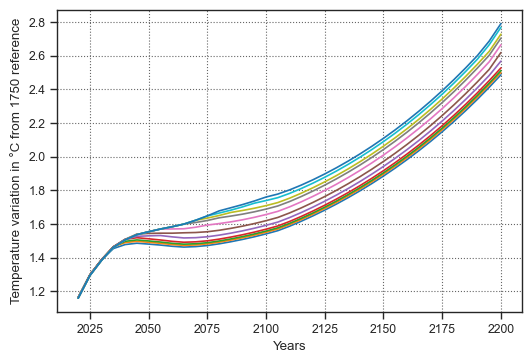

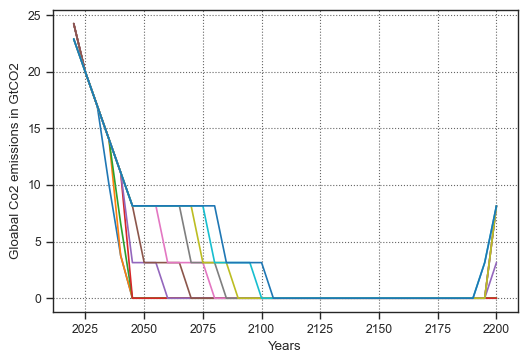

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')

X = np.arange(T)* 5 + 2020

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, eval_scm(path_, scm)[0])
plt.xlabel('Years')
plt.ylabel('Temperature variation in °C from 1750 reference')
plt.show()

plt.figure(dpi=100)
for path_ in paths: 
    plt.plot(X, path_)
plt.xlabel('Years')
plt.ylabel('Gloabal Co2 emissions in GtCO2')

plt.show()

# fig, ax = plt.subplots(nrows=4,ncols=3, dpi=140, figsize=(9,6))
# for k, result in enumerate(results):
#     for i in range(N):
#         ax[k//3,k%3].plot(X, result.x.reshape((T,N)).T[i])

plt.show()